<a href="https://colab.research.google.com/github/julianasaha/Project-2/blob/main/Copy_of_Project_2_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risk of Stroke Prediction (Project 2)
- Juliana Sahagun
- 07/06/22

Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Description of Data:

>  This dataset is used to predict whether a patient is at risk for stroke based on the features: gender, age, various diseases, and smoking status.


Target:

> 'stroke'


Classification Problem

> Is this person likely to have a stroke ?
0: NO
1: YES

Size of the Data

>5110 rows, 12 columns

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline as smote_pipe
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [3]:
# Load the dataset
df =pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Explore and Clean the Data

In [4]:
# Delete unnecessary columns
df.drop(columns='id', inplace=True)

- 'id' has all unique values and no correlation with the target therefore we can drop this column.

In [ ]:
# Delete duplicate rows
df.duplicated().sum()

0

In [6]:
# Identify missing values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# Look at the rows with missing values to see if there's a pattern 
df[df['bmi'].isnull()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


-  There is no clear pattern between all the rows with missing data.

In [ ]:
# Drop rows with missing data
df.dropna(inplace=True)

- The percentage of missing data is less than 1% therefore I decided to remove the rows with NaN to not introduce any errors to the data.

In [ ]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


In [ ]:
# Convert the age column from float to integer
df['age'] = df['age'].astype(int)

# Convert bmi from object to float since its a numeric column
df['bmi'] = df['bmi'].astype(float)

- Judgement call: ages less than one are babies who haven't turned one years old yet

In [ ]:
# Find outliers
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.854145,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.575986,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
# Check for inconsistencies in categorical values
obj_cols = df.dtypes[df.dtypes=='object'].index

# Create a loop to examine the object type columns
for col in obj_cols:
  print(f'Column: {col}')
  print(df[col].value_counts(dropna=False))
  print('\n')

Column: gender
Female    2897
Male      2011
Other        1
Name: gender, dtype: int64


Column: ever_married
Yes    3204
No     1705
Name: ever_married, dtype: int64


Column: work_type
Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64


Column: Residence_type
Urban    2490
Rural    2419
Name: Residence_type, dtype: int64


Column: smoking_status
never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64




In [ ]:
# Drop the row where 'Other' is located
other= df[df['gender']=='Other'].index

df.drop(other,inplace=True)

- There is only one value for 'Other' therefore it is insignificant in our data.

#Visuals

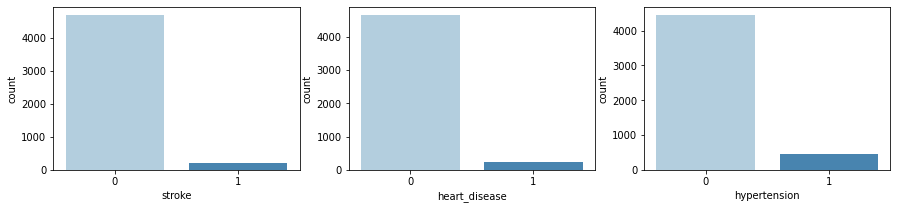

In [ ]:
# Create a countplot fot the target and features with two numeric options 
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,3))

sns.countplot(data=df,x='hypertension', palette='Blues', ax=axes[2])
sns.countplot(data=df,x='heart_disease',palette='Blues', ax=axes[1])
sns.countplot(data=df,x='stroke',palette='Blues', ax=axes[0])

plt.rcParams.update( {'font.family':'serif', 'font.size':5,
                      'font.weight':'bold'})

- Countplots above demostrate have many value counts they are for each feature.



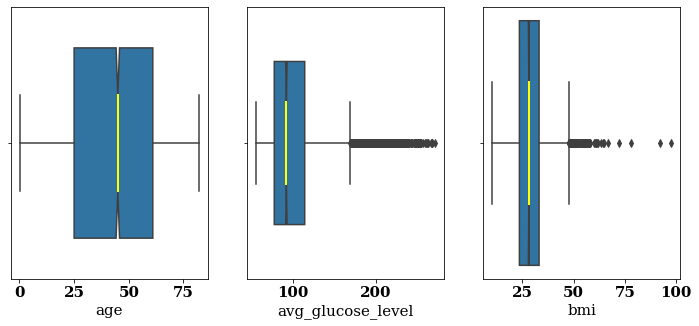

In [9]:
#Creat a univariate boxplot for columns with different numeric ranges
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12,5))

sns.boxplot(data=df, x='age',medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),notch=True,
          width = .7,ax=axes[0])
sns.boxplot(data=df, x='avg_glucose_level',medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),notch=True, 
          width = .6,ax=axes[1])
sns.boxplot(data=df, x='bmi',medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),notch=True, 
          width = .9,ax=axes[2])
plt.rcParams.update( {'font.family':'serif', 'font.size':15,
                      'font.weight':'bold'})

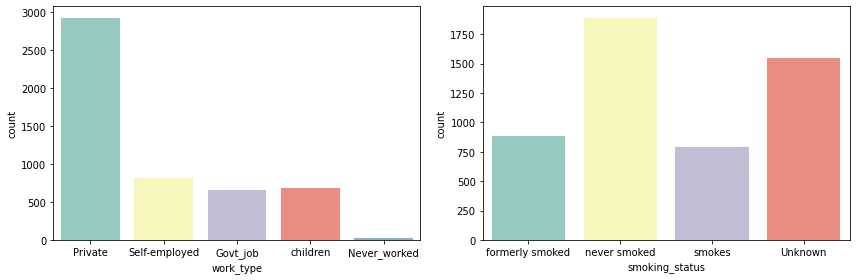

In [7]:
# Create univariate countplot with columns with multiple caterogories
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

sns.countplot(data = df, x='work_type', palette='Set3', ax=axes[0])
sns.countplot(data = df, x='smoking_status', palette='Set3', ax=axes[1])
fig.tight_layout()
plt.rcParams.update({'font.family':'serif', 'font.size':5,
                      'font.weight':'bold'})

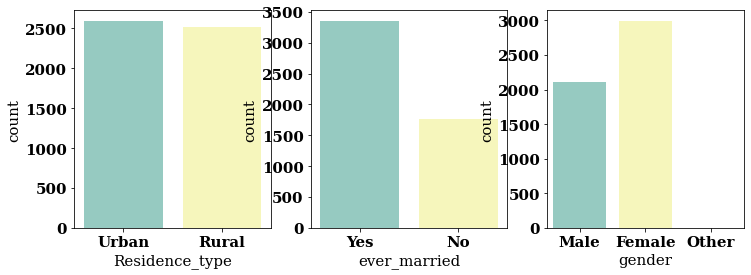

In [10]:
# Create univariate countplot with columns with two caterogories
fig, axes = plt.subplots(ncols=3, figsize=(12,4))

sns.countplot(data = df, x='Residence_type', palette='Set3', ax=axes[0])
sns.countplot(data = df, x='ever_married', palette='Set3', ax=axes[1])
sns.countplot(data = df, x='gender', palette='Set3', ax=axes[2])

plt.rcParams.update( {'font.family':'serif', 'font.size':9,
                      'font.weight':'semibold'})

In [ ]:
# install dython to make a corr heatmap
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 7.0 MB/s 
     |████████████████████████████████| 944 kB 39.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


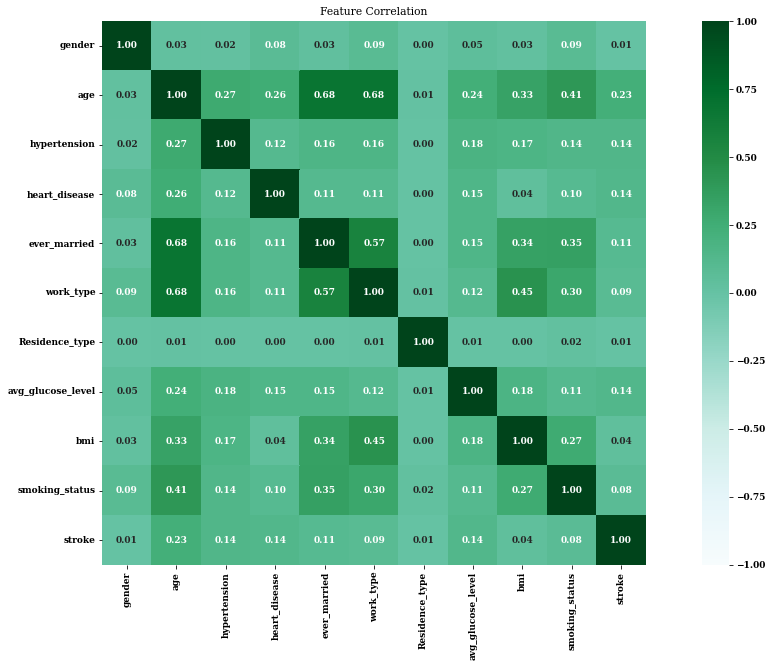

In [ ]:
# Create a heatmap with numeric & categorical features
from dython.nominal import associations
associations(df, figsize=(20,10), cmap="BuGn", title='Feature Correlation', cbar=True);

-  strongest correlations in heatmap:

1.   'ever_married' and 'age'
2.   'work_type' and 'age'

- moderate correlations in heatmap:

1.   'work_type' and 'bmi'
3.   'age' and 'smoking_status'
4.   'age' and 'bmi'
5.   'hypertension' and 'age'




In [ ]:
# Create scatterplots for the numeric data
fig, axes = plt.subplots(ncols=4, figsize=(15,4))

sns.scatterplot(data=df, x = 'bmi', y = 'age', hue = 'gender', palette = 'Set2', ax=axes[0])
#ax.legend()
axes[0].set_title('BMI in Age Range');

sns.scatterplot(data=df, x = 'avg_glucose_level', y = 'age', hue = 'gender', palette = 'Set2',ax=axes[1])
axes[1].set_title('Avg Glucose Level in Age Range');
sns.scatterplot(data=df, x = 'heart_disease', y = 'age', hue = 'gender', palette = 'Set2',ax=axes[2])
axes[2].set_title('Heart Disease in Age Range');
sns.scatterplot(data=df, x = 'hypertension', y = 'age', hue = 'gender', palette = 'Set2',ax=axes[3])
axes[3].set_title('Hypertension in Age Range');



- The scatterplots above represent the condition levels for the age range for each gender.

In [ ]:
# Create catplots for the caterogical features
fig, axes = plt.subplots(ncols=3, figsize=(21,5))

sns.barplot(x='ever_married',y='stroke', hue="work_type", data=df,ax=axes[0], palette='Set2',ci=None)
sns.barplot(x="Residence_type", y="stroke", hue="work_type", data=df,ax=axes[1], palette='Set2',ci=None)
sns.barplot(x="smoking_status", y="stroke", hue='work_type', data=df,ax=axes[2], palette='Set2',ci=None)

-  The barplots demonstrates if the work type and other features like ever married, residence type and smoking status are at high risk for stroke.

# Key Findings

In [ ]:
# Create barplots for each condition
fig, axes = plt.subplots(ncols=4, figsize=(15,4))

sns.barplot(data=df,x='gender',y='heart_disease',hue='stroke', palette='Set2',ax=axes[0],ci=None)
axes[0].set_title('Heart Disease', fontsize = 15, fontweight = 'bold');

sns.barplot(data=df,x='gender',y='hypertension',hue='stroke', palette='Set2',ax=axes[1],ci=None);
axes[1].set_title('Hypertension', fontsize = 15, fontweight = 'bold')

sns.barplot(data=df, x='gender',y='avg_glucose_level', hue='stroke', palette='Set2', ax=axes[2],ci=None)
axes[2].set_title('Avg Glucose Level', fontsize = 15, fontweight = 'bold')

sns.barplot(data=df,x='gender',y='bmi',hue='stroke', palette='Set2',ax=axes[3],ci=None)
axes[3].set_title('BMI', fontsize = 15, fontweight = 'bold')

fig.suptitle('Stroke Results within each Gender Among Different Conditons', fontsize = 20, fontweight = 'bold', y=1.05)
fig.tight_layout()

- From analyzing the data, we see that Heart Disease is a bigger risk factor for men than females but Hypertension seems to be a bigger risk for females than men. Men and females who aren't at risk have moderate glucose levels while patients who are at risk tend to have higher glucose levels. BMI for stroke patients is slightly higher than not at risk patients.Heart Disease, Hypertension and Glucose levels are major indicators for stroke prediction because there is a distinct difference between the two classes.

# Preprocessing

In [ ]:
# Set target and fetures
y = df['stroke']
X = df.drop(columns = 'stroke')

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [ ]:
# Make column selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Instantiate OHE for categorical features and StandardScaler for numerical features
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

# Make tuples for preprocessing the categorical and numeric columns
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)

# Make a column transformer to match the transformation to the type of column
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

# fit the transformer 
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])

In [ ]:
# Evaluation function for testing models
def evaluate_classification(model,X_train,X_test,y_train,y_test):
    print(f"Training Accuracy: {model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {model.score(X_test, y_test):.3f}")

# Logistic Regression

In [ ]:
# Instantiate the model
logreg = LogisticRegression(class_weight='balanced')

# Scale Loigistic Regression (preprocessor includes already a scaler)
# Make pipeline
logreg_pipe= make_pipeline(preprocessor, logreg)

# Fit data on train
logreg_pipe.fit(X_train, y_train)

# Evaluate the model 
evaluate_classification(logreg_pipe, X_train, X_test, y_train, y_test)


Training Accuracy: 0.735
Test Accuracy: 0.747


In [ ]:
# Looking at some hyperparameters that seem tunable
logreg_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [ ]:
# Create a parameter grid dictionary
logreg_params = {'logisticregression__C': [0.1,0.7,1,10],
                 'logisticregression__max_iter': [0.001, 0.1, 1, 10, 100]}

In [ ]:
# Instantiate the GridSearchCV class
lg_grid_search = GridSearchCV(logreg_pipe, logreg_params)

# Fit on training data
lg_grid_search.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])),
                                       ('logistic

In [ ]:
# Look at the best parameters found by the search
lg_grid_search.best_params_

{'logisticregression__C': 0.7, 'logisticregression__max_iter': 100}

In [ ]:
# Examine and evaluate the best version of the model
best_lg_model = lg_grid_search.best_estimator_ 

# Refit the model on the whole training set
best_lg_model.fit(X_train, y_train)

# Score the model on the test set
best_lg_model.score(X_test, y_test)

0.7465362673186634

In [ ]:
%%time
preds_no_pca = logreg_pipe.predict(X_test)


CPU times: user 14.6 ms, sys: 11.8 ms, total: 26.4 ms
Wall time: 23.8 ms


In [ ]:
# Show the report of the different metrics
print('Classification Report for Logistic Regression Final Model')
test_report=classification_report(y_test, best_lg_model.predict(X_test))
print(test_report)

Classification Report for Logistic Regression Final Model
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1164
           1       0.15      0.83      0.25        63

    accuracy                           0.75      1227
   macro avg       0.57      0.78      0.55      1227
weighted avg       0.94      0.75      0.82      1227



# Logistic Regression with PCA

In [ ]:
pca=PCA(.95)
lg_pca_pipe= make_pipeline(preprocessor, pca, logreg)
lg_pca_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [ ]:
%%time
preds_pca = lg_pca_pipe.predict(X_test)


CPU times: user 19.5 ms, sys: 18.2 ms, total: 37.7 ms
Wall time: 36 ms


In [ ]:
%%time
# Evaluate the model using classification_report
print(classification_report(y_test, lg_pca_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1164
           1       0.15      0.86      0.25        63

    accuracy                           0.74      1227
   macro avg       0.57      0.79      0.55      1227
weighted avg       0.95      0.74      0.81      1227

CPU times: user 28.8 ms, sys: 19.2 ms, total: 48 ms
Wall time: 45.9 ms


# Decision Tree Classifier

In [ ]:
# Default Decision Tree Model
# Instantiate the model
dec = DecisionTreeClassifier(class_weight='balanced')

# Make pipeline
dec_pipe= make_pipeline(preprocessor, dec)

# Fit data on train
dec_pipe.fit(X_train, y_train)

# Evaluate the model
evaluate_classification(dec_pipe, X_train, X_test, y_train, y_test)

Training Accuracy: 1.000
Test Accuracy: 0.923


In [ ]:
# Looking at some hyperparameters that seem tunable
dec_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [ ]:
# Create a parameter grid dictionary
dec_tree_params= {'decisiontreeclassifier__max_depth':[4,20,2],
                  'decisiontreeclassifier__min_samples_split': [5,2,1],
                  'decisiontreeclassifier__min_samples_leaf': [1,2,3]}


In [ ]:
#  Instantiate the GridSearchCV class
dec_gs = GridSearchCV(dec_pipe, dec_tree_params)

# Fit on training data
dec_gs.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/s

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])),
                                       ('decision

In [ ]:
dec_gs.best_params_

{'decisiontreeclassifier__max_depth': 20,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

In [ ]:
# Examine and evaluate the best version of the model
best_dec_model = dec_gs.best_estimator_

# Refit the model on the whole training set
best_dec_model.fit(X_train, y_train)

# Score the model on the test set
best_dec_model.score(X_test, y_test)

0.9250203748981255

In [ ]:
# Show the report of the different metrics
print('Classification Report for DecisionTree Final Model')
test_report=classification_report(y_test, best_dec_model.predict(X_test))
print(test_report)

Classification Report for DecisionTree Final Model
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1164
           1       0.09      0.05      0.06        63

    accuracy                           0.93      1227
   macro avg       0.52      0.51      0.51      1227
weighted avg       0.91      0.93      0.91      1227



In [ ]:
%%time
preds_no_pca = dec_pipe.predict(X_test)


CPU times: user 10.8 ms, sys: 1.28 ms, total: 12 ms
Wall time: 13 ms


# Decision Tree with PCA

In [ ]:
pca=PCA(.95)
dc_pca_pipe= make_pipeline(preprocessor, pca, dec)
dc_pca_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])),
                ('pca', PCA(n_components=0.95)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [ ]:
%%time
preds_pca_dc = dc_pca_pipe.predict(X_test)


CPU times: user 17.1 ms, sys: 13 ms, total: 30.1 ms
Wall time: 28.9 ms


In [ ]:
%%time
# Evaluate the model using classification_report
print(classification_report(y_test, dc_pca_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1164
           1       0.06      0.05      0.05        63

    accuracy                           0.91      1227
   macro avg       0.51      0.50      0.50      1227
weighted avg       0.90      0.91      0.91      1227

CPU times: user 26.2 ms, sys: 3.8 ms, total: 30 ms
Wall time: 24.3 ms


# K Nearest Neighbors

In [ ]:
# Instantiate the model
knn = KNeighborsClassifier()

# Make pipeline
knn_pipe = make_pipeline(preprocessor,knn)
# Fit data on train data
knn_pipe.fit(X_train, y_train)

# Evaluate the model
evaluate_classification(knn_pipe, X_train, X_test, y_train, y_test)

Training Accuracy: 0.959
Test Accuracy: 0.948


In [ ]:
# Looking at some hyperparameters that seem tunable
knn_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [ ]:
# Create a parameter grid
knn_params = {'kneighborsclassifier__n_neighbors':[10,5,20],
              'kneighborsclassifier__p':[4,3,9],
              'kneighborsclassifier__leaf_size':[30,40,25],
              'kneighborsclassifier__weights':['uniform', 'distance'],
              'kneighborsclassifier__metric':['euclidean', 'manhattan', 'minkowski']}

In [ ]:
# Instantiate the GridSearchCV class
knn_gs = GridSearchCV(knn_pipe, knn_params)

# Fit on training data
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])),
                                       ('kneighbo

In [ ]:
# Look the best parameters found by the search
knn_gs.best_params_

{'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'euclidean',
 'kneighborsclassifier__n_neighbors': 10,
 'kneighborsclassifier__p': 4,
 'kneighborsclassifier__weights': 'uniform'}

In [ ]:
# Examine and evaluate the best version of the model
best_knn_model = knn_gs.best_estimator_

# Refit the model on the whole training set
best_knn_model.fit(X_train, y_train)

# Score the model on the test set
best_knn_model.score(X_test, y_test)

0.9486552567237164

In [ ]:
# Show the report of the different metrics
print('Classification Report for KNN Final Model')
test_report=classification_report(y_test,best_knn_model.predict(X_test))
print(test_report)

Classification Report for KNN Final Model
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1164
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1227
   macro avg       0.47      0.50      0.49      1227
weighted avg       0.90      0.95      0.92      1227



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN with PCA

In [ ]:
pca=PCA(.95)
knn_pca_pipe= make_pipeline(preprocessor, pca, knn)
knn_pca_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf7d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb448ecf490>)])),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
%%time
preds_pca_dc = knn_pca_pipe.predict(X_test)


CPU times: user 125 ms, sys: 85.9 ms, total: 211 ms
Wall time: 142 ms


In [ ]:
%%time
# Evaluate the model using classification_report
print(classification_report(y_test, knn_pca_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1164
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1227
   macro avg       0.47      0.50      0.49      1227
weighted avg       0.90      0.95      0.92      1227

CPU times: user 127 ms, sys: 90 ms, total: 217 ms
Wall time: 128 ms


# Final Decision 

When it comes to data pertaining information about one's health, there needs to be a high recall and precision score because errors can lead to bad consequences. After tuning the hyperparameters of the three different models, none of my models gave me acceptable results. None of the models were able to predict the target even after balancing out the two classes in the data.